In [1]:
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as mdates
import pandas as pd

Connecting austin@datajoint-rds.cyuksi65nrdq.us-east-1.rds.amazonaws.com:3306


In [2]:
from psychofit import psychofit as psy

In [3]:
from behavior_plots import *

In [4]:
from load_mouse_data import *

In [5]:
ibl17 = (subject.Subject() & 'subject_nickname = "IBL_17"').fetch1()

## Weight over time

In [6]:
wei = {}
wei['date_time'], wei['weight'] = (action.Weighing() & ibl17).fetch('weighing_time', 'weight', order_by='weighing_time')

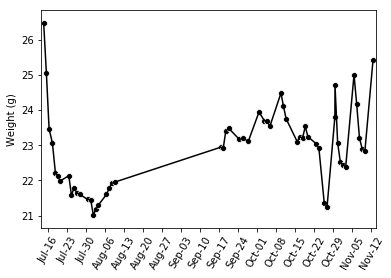

In [7]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="date_time", y="weight", color="black", markers=True, data=wei, ax=ax)
sns.scatterplot(x="date_time", y="weight", color="black", data=wei, ax=ax)
ax.set(xlabel='', ylabel="Weight (g)", 
xlim=[wei['date_time'].min()-timedelta(days=1), wei['date_time'].max()+timedelta(days=1)])
fix_date_axis(ax)

## Water intake

In [10]:
def dj_get_water(mousename):
    w = (action.WaterAdministration() & ibl17).fetch(as_dict=True)
    w = pd.DataFrame(w)
    w.rename(columns={'administration_time':'date_time'}, inplace=True)
    w['date_time'] = pd.to_datetime(w.date_time)
    w.sort_values('date_time', inplace=True)
    w.reset_index(drop=True, inplace=True)
    w['date'] = w['date_time'].dt.floor('D')
    w['days'] = w.date - w.date[0]
    w['days'] = w.days.dt.days
    w = w.set_index('date')
    w.index = pd.to_datetime(w.index)
    wa_unstacked = w.pivot_table(index='date', 
        columns='watertype_name', values='water_administered', aggfunc='sum').reset_index()
    wa_unstacked['date'] = pd.to_datetime(wa_unstacked.date)
    wa_unstacked.set_index('date', inplace=True)
    return wa_unstacked, w

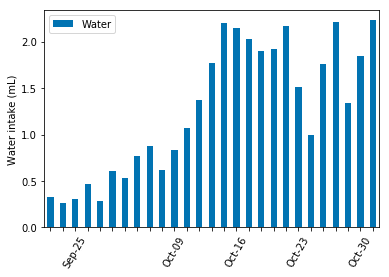

In [12]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.set_palette("colorblind") # palette for water
wa_unstacked, wa = dj_get_water(ibl17)
wa_unstacked.loc[:,['Water']].plot.bar(stacked=True, ax=ax)
l = ax.legend()
l.set_title('')
ax.set(ylabel="Water intake (mL)", xlabel='')

# fix dates, known to be an issue in pandas/matplotlib
ax.set_xticklabels([dt.strftime('%b-%d') if dt.weekday() is 1 else "" for dt in wa_unstacked.index.to_pydatetime()])
for item in ax.get_xticklabels():
    item.set_rotation(60)

## Performance on easy trials

In [ ]:
def get_behavior(mousename, **kwargs):

    # find metadata we need
    eid, details = one.search(subjects=mousename, details=True, **kwargs)

    # sort by date so that the sessions are shown in order
    start_times  = [d['start_time'] for d in details]
    eid          = [x for _,x in sorted(zip(start_times, eid))]
    details      = [x for _,x in sorted(zip(start_times, details))]

    # grab only behavioral datatypes, all start with _ibl_trials
    types       = one.list(eid)
    types2      = [item for sublist in types for item in sublist]
    types2      = list(set(types2)) # take unique by converting to a set and back to list
    dataset_types = [s for i, s in enumerate(types2) if '_ibl_trials' in s]

    # load data over sessions
    for ix, eidx in enumerate(eid):
        dat = one.load(eidx, dataset_types=dataset_types, dclass_output=True)

        # skip if no data, or if there are fewer than 10 trials in this session
        if len(dat.data) == 0:
            continue
        else:
            if len(dat.data[0]) < 10:
                continue

        # pull out a dict with variables and their values
        tmpdct = {}
        for vi, var in enumerate(dat.dataset_type):
            k = [item[0] for item in dat.data[vi]]
            tmpdct[re.sub('_ibl_trials.', '', var)] = k

        # add crucial metadata
        tmpdct['subject']       = details[ix]['subject']
        tmpdct['users']         = details[ix]['users'][0]
        tmpdct['lab']           = details[ix]['lab']
        tmpdct['session']       = details[ix]['number']
        tmpdct['start_time']    = details[ix]['start_time']
        tmpdct['end_time']      = details[ix]['end_time']
        tmpdct['trial']         = [i for i in range(len(dat.data[0]))]

        # append all sessions into one dataFrame
        if not 'df' in locals():
            df = pd.DataFrame.from_dict(tmpdct)
        else:
            df = df.append(pd.DataFrame.from_dict(tmpdct), sort=False, ignore_index=True)

    # take care of dates properly
    df['start_time'] = pd.to_datetime(df.start_time)
    df['end_time']   = pd.to_datetime(df.end_time)
    df['date']       = df['start_time'].dt.floor("D")

    # convert to number of days from start of the experiment
    df['days']       = df.date - df.date[0]
    df['days']       = df.days.dt.days

    # add some more handy things
    df['rt']        = df['response_times'] - df['stimOn_times']
    df['signedContrast'] = (df['contrastLeft'] - df['contrastRight']) * 100
    df['signedContrast'] = df.signedContrast.astype(int)

    df['correct']   = np.where(np.sign(df['signedContrast']) == df['choice'], 1, 0)
    df.loc[df['signedContrast'] == 0, 'correct'] = np.NaN

    df['choice2'] = df.choice.replace([-1, 0, 1], [0, np.nan, 1]) # code as 0, 100 for percentages
    df['probabilityLeft'] = df.probabilityLeft.round(decimals=2)

    return df

In [ ]:
behav = dj_get_behavior(ibj17)

NameError: name 'behav' is not defined

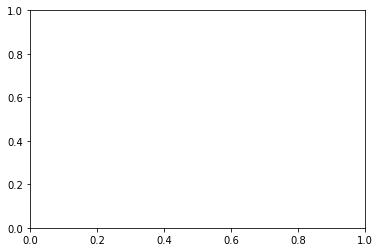

In [14]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
behav['correct_easy'] = behav.correct
behav.loc[np.abs(behav['signedContrast']) < 50, 'correct_easy'] = np.NaN
correct_easy = behav.groupby(['start_time'])['correct_easy'].mean().reset_index()

sns.lineplot(x="start_time", y="correct_easy", markers=True, color="black", data=correct_easy, ax=ax)
sns.scatterplot(x="start_time", y="correct_easy", color="black", data=correct_easy, ax=ax)
ax.set(xlabel='', ylabel="Performance on easy trials", 
    xlim=[behav.date.min()-timedelta(days=1), behav.date.max()+timedelta(days=2)],
    yticks=[0.5, 0.75, 1], ylim=[0.4, 1.01])
ax.yaxis.label.set_color("black")

# overlay trial counts
trialcounts = behav.groupby(['start_time'])['trial'].max().reset_index()
righty = ax.twinx()
sns.lineplot(x="start_time", y="trial", markers=True, color="firebrick", data=trialcounts, ax=righty)
sns.scatterplot(x="start_time", y="trial", color="firebrick", data=trialcounts, ax=righty)
righty.yaxis.label.set_color("firebrick")
righty.grid(False)
fix_date_axis(righty)
fix_date_axis(ax)
righty.set(xlabel='', ylabel="Trial count", 
xlim=[behav.date.min()-timedelta(days=1), behav.date.max()+timedelta(days=2)])